In [1]:
%matplotlib inline
import tensorflow_addons as tfa
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from datetime import datetime
from tensorflow.keras.metrics import top_k_categorical_accuracy, CategoricalHinge, Recall, Precision
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.backend as K
# from tensorflow.keras import metrics

import tensorflow.keras
from tensorflow.compat.v2.keras.layers import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
import h5py
import os

tf.compat.v1.disable_eager_execution
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)


#np.random.seed(368)
#tf.random.set_seed(368)

In [15]:
xfile='C:\\workspace\\j6stock\\xau_usd_OHLC2.0Tp1.0Cl100Vp.txt'

seq_len = 60*6 #60*10 # 3 days + 2 features is enough memory
batch_size = int(2048/3)       # Batch size
# mini_batch_size = 64       # Batch size

learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 500
dropout_rate= 0.5

y_column = 6
compute_val_at = 0
acc_filtered_r = 0.8


upperTailFilter = 0.4
lowerTailFilter = 0.4

import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
#from keras.models import load_model
#import keras
import pandas as pd ## can be remove once pandas_datareader 0.7 using
pd.core.common.is_list_like = pd.api.types.is_list_like ## can be remove once pandas_datareader 0.7 using
import pandas_datareader.data as web



def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    global upperTailFilter, lowerTailFilter
    
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    df['tail_upper'] = df['high'].copy()
    df['tail_lower'] = df['low'].copy()
    for i, row in df.iterrows():
        df.at[i, 'tail_upper'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'tail_lower'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    
    df.dropna(inplace=True)
    df.drop('open', axis=1, inplace=True)
    df.drop('high', axis=1, inplace=True)
    df.drop('low', axis=1, inplace=True)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean() 
    df.dropna(inplace=True)
    
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        #df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        #df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
#         df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1)) # no rescale for keep the negative value
        df['tail_upper'] = min_max_scaler.fit_transform(df['tail_upper'].values.reshape(-1,1))
        upperTailFilter = min_max_scaler.transform([[upperTailFilter]])[0][0] 
        df['tail_lower'] = min_max_scaler.fit_transform(df['tail_lower'].values.reshape(-1,1))
        lowerTailFilter = min_max_scaler.transform([[lowerTailFilter]])[0][0] 
        
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))   
                #pd.concat([min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1)), df], axis=1)
                ma_data = df['{}ma'.format(moving)]
                df.drop(labels=['{}ma'.format(moving)], axis=1, inplace=True)
                df = pd.concat([ma_data, df], axis=1)
    df.dropna(inplace=True)

    
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)

    return df

#df = get_stock_data( ma=[50, 100, 200])
df = get_stock_data(ma=[5, 60, 240])

# amount_of_features = len(df.columns)-1+(input2Length*-1)

# def load_data(stock, seq_len):
#     print ("Amount of features = {}".format(amount_of_features))
#     data = stock.as_matrix()
#     sequence_length = seq_len + 1 # index starting from 0
#     x_result = []
#     x_result2 = []
#     y_result = []
#     for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
#         x_result.append(data[index-seq_len: index,
#                              :-1 + (input2Length*-1) # -2 is ignore Input2 features
#                             ]) # index : index + 22days
#         x_result2.append(data[index, -1 + (input2Length*-1):-1])
#         y_result.append(data[index ,-1]);

#     x_result, x_result2, y_result = shuffle(x_result, x_result2, y_result , random_state=2)

#     #print('---', data[0])
#     #print('---', x_result[0])
#     #print('---', y_result[0])
#     x_result = np.array(x_result)
#     x_result2 = np.array(x_result2)
#     y_result = np.array(y_result)
#     print ("Amount of data = {}".format(y_result.shape[0]))

#     percentageSplit = 0.5 # 60% split
#     row = round(percentageSplit * y_result.shape[0]) 
#     print ("Split = {}".format(row))
 
#     X_train = x_result[:int(row), :] 
#     X_train2 = x_result2[:int(row), :] 
#     y_train = y_result[:int(row)] 
#     print ("Amount of training data = {}".format(y_train.shape[0]))
#     X_test = x_result[int(row):, :]
#     X_test2 = x_result2[int(row):, :]
#     y_test = y_result[int(row):]
#     # filter for 1 and -1 for validation only
#     X_test = X_test[y_test[:]!=0,:]
#     X_test2 = X_test2[y_test[:]!=0,:]
#     y_test = y_test[y_test[:]!=0]
    
#     # split 50% again for test and validation set
#     row = round(percentageSplit * y_test.shape[0]) 
#     X_val = X_test[int(row):, :]
#     X_val2 = X_test2[int(row):, :]
#     y_val = y_test[int(row):]
#     print ("Amount of validation data = {}".format(y_val.shape[0]))
#     X_test = X_test[:int(row), :]
#     X_test2 = X_test2[:int(row), :]
#     y_test = y_test[:int(row)]
#     print ("Amount of testing data = {}".format(y_test.shape[0]))
#     #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
#     #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
#     #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))    
#     return [X_train, X_train2, y_train, X_test, X_test2, y_test, X_val, X_val2, y_val]



classes = [1, 0, -1]
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.transform([-1, 0, 1])

df_to_dataset = df[[ 'change', '5ma', '60ma', '240ma'
                   ]].copy()
df_to_dataset_input2 = df[[ 'tail_upper', 'tail_lower', 'change' ,'cross_360p_high', 'cross_1440p_high'
                          ]].copy()

amount_of_features = len(df_to_dataset.columns)
input2Length = len(df_to_dataset_input2.columns)

df.drop(labels=['close'], axis=1, inplace=True)
df.drop(labels=['change'], axis=1, inplace=True)
df.drop(labels=['tail_upper'], axis=1, inplace=True)
df.drop(labels=['tail_lower'], axis=1, inplace=True)
df.drop(labels=['cross_360p_high'], axis=1, inplace=True)
df.drop(labels=['cross_1440p_high'], axis=1, inplace=True)

df_to_dataset_y = lb.transform(df[['y_result']].copy())
df.drop(labels=['y_result'], axis=1, inplace=True)

train_data_no = int(len(df_to_dataset_y)/2)
test_data_no = int(train_data_no/2)
v_data_no = test_data_no

train_x_1 = df_to_dataset.iloc[:train_data_no].values
train_x_2 = df_to_dataset_input2.iloc[:train_data_no].values
train_y = df_to_dataset_y[:train_data_no]                                                   

test_x_1 = df_to_dataset.iloc[train_data_no:train_data_no+test_data_no].values
test_x_2 = df_to_dataset_input2.iloc[train_data_no:train_data_no+test_data_no].values
test_y = df_to_dataset_y[train_data_no:train_data_no+test_data_no]                                                   

v_x_1 = df_to_dataset.iloc[train_data_no+test_data_no:].values
v_x_2 = df_to_dataset_input2.iloc[train_data_no+test_data_no:].values
v_y = df_to_dataset_y[train_data_no+test_data_no:]                                                   


def make_window_dataset(ds, window_size=seq_len, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def batch(sub):
    ret = ()
    for index in range(2):
      ret = ret + ( sub[index].batch(window_size, drop_remainder=True), )
    return ret
  def sub_to_batch(sub, sub2): 
    return tf.data.Dataset.zip((batch(sub), (sub2.batch(window_size, drop_remainder=True))))
  
  windows = windows.flat_map(sub_to_batch)
  windows = windows.map(lambda sub1, sub2: ((sub1[0], sub1[1][-1:][0]), (sub2[-1:][0] #, sub2[-1:][0]
                                                                        )))
  return windows

def filter_fn(a, b):
#   return a[1][0]>=upperTailFilter or a[1][1]>=lowerTailFilter or a[1][3]==1 or a[1][4]==1
  return a[1][4]==1

train_dataset_x = tf.data.Dataset.from_tensor_slices(((train_x_1, train_x_2),(train_y)))
train_dataset = make_window_dataset(train_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True) 

test_dataset_x = tf.data.Dataset.from_tensor_slices(((test_x_1, test_x_2),(test_y)))
test_dataset = make_window_dataset(test_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True)

v_dataset_x = tf.data.Dataset.from_tensor_slices(((v_x_1, v_x_2),(v_y)))
v_dataset = make_window_dataset(v_dataset_x).filter(filter_fn).cache().batch(batch_size, drop_remainder=True)


print('Total Size : {}'.format(train_dataset_x))
print('Total Filtered Size : {}'.format(v_dataset_x))


# X_tr, X_tr2, lab_tr, X_test, X_test2, lab_test, X_vld, X_vld2, lab_vld = load_data(df, seq_len)
# y_tr = lb.transform(lab_tr)
# y_vld = lb.transform(lab_vld)
# y_test = lb.transform(lab_test)


# train_X = X_tr
# train_X2 = X_tr2
# train_y = y_tr
# valid_X = X_vld
# valid_X2 = X_vld2
# valid_y = y_vld
# test_X = X_test
# test_X2 = X_test2
# test_y = y_test

# print(train_X.shape)
# print(train_y[0])
# print(train_y[1])
# print(train_y[2])

Total Size : <TensorSliceDataset shapes: (((4,), (5,)), (3,)), types: ((tf.float64, tf.float64), tf.int32)>
Total Filtered Size : <TensorSliceDataset shapes: (((4,), (5,)), (3,)), types: ((tf.float64, tf.float64), tf.int32)>


In [16]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='tanh')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [83]:

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
def CnnTransformerModel():
#    i = tf.compat.v2.keras.layers.Flatten(input_shape=(batch_size, amount_of_features))
    i = tf.compat.v2.keras.layers.Input(shape = (seq_len, amount_of_features)#, batch_size=mini_batch_size
                                       )
    
    x = tf.compat.v2.keras.layers.Convolution1D(64*2, kernel_size = 3, dilation_rate=2)(i)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(x)
    x = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 3, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(x)    
    x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 3, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x) 
    x = tf.compat.v2.keras.layers.Convolution1D(16, kernel_size = 3, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.compat.v2.keras.layers.Convolution1D(8, kernel_size = 3, dilation_rate=2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    
    x2 = tf.compat.v2.keras.layers.LocallyConnected1D(64*2, kernel_size = 3, strides=2)(i)
    x2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(i)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=0.2)(x2)
    x2 = tf.compat.v2.keras.layers.LocallyConnected1D(64, kernel_size = 3, strides=2)(i)
    x2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(x2)
    x2 = tf.compat.v2.keras.layers.BatchNormalization()(x2)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=dropout_rate)(x2)
    x2 = tf.compat.v2.keras.layers.LocallyConnected1D(32, kernel_size = 3, strides=2)(x2)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=dropout_rate)(x2)
    x2 = tf.compat.v2.keras.layers.LocallyConnected1D(16, kernel_size = 3, strides=2)(x2)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=dropout_rate)(x2)
    x2 = tf.compat.v2.keras.layers.LocallyConnected1D(8, kernel_size = 3, strides=2)(x2)
    x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
    x2 = tf.keras.layers.Dropout(rate=dropout_rate)(x2)
    
#     x2 = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 3, strides=2)(x2)
#     x2 = tf.keras.layers.MaxPool1D(pool_size=2, pool_size=1)(x2)
#     x2 = tf.compat.v2.keras.layers.BatchNormalization()(x2)
#     x2 = tf.compat.v2.keras.layers.Activation('tanh')(x2)
#     x2 = tf.keras.layers.Dropout(rate=dropout_rate)(x2)

#     x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, strides = 2)(x)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
#     x = tf.compat.v2.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.Dropout(rate=0.2)(x)
#     x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
#     x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, dilation_rate=5)(x)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
#     x = tf.compat.v2.keras.layers.Activation('relu')(x)
#     x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
#     x, slf_attn = MultiHeadAttention(n_head=int(80), d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    avg_pool2 = GlobalAveragePooling1D()(x2)
    max_pool2 = GlobalMaxPooling1D()(x2)
    
#     x = Dense(300)(concatenate([max_pool, avg_pool, max_pool2, avg_pool2]))
#     x = BatchNormalization()(x)
#     x = Activation('tanh')(x)
#     x = Dropout(dropout_rate)(x)
    
#     x = Dense(600)(x)
#     x = BatchNormalization()(x)
#     x = Activation('tanh')(x)
#     x = Dropout(dropout_rate)(x)

#     x = Dense(1200)(x)
#     x = BatchNormalization()(x)
#     x = Activation('tanh')(x)
#     x = Dropout(dropout_rate)(x)

#     x = Dense(600)(x)
#     x = BatchNormalization()(x)
#     x = Activation('tanh')(x)    
#     x = Dropout(dropout_rate)(x)

#     x = Dense(300)(x)
#     x = BatchNormalization()(x)
#     x = Activation('tanh')(x)    
#     x = Dropout(dropout_rate)(x)
    
#     x = Dense(130)(x)
#     x = BatchNormalization()(x)
#     x = Activation('tanh')(x)    
#     x = Dropout(dropout_rate)(x)
    
    x = Dense(70)(concatenate([max_pool, avg_pool, max_pool2, avg_pool2]))
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(dropout_rate)(x)
    
    x = Dense(35)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(dropout_rate)(x)
    
    x = Dense(15)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)    
    x = Dropout(dropout_rate)(x)
    
    x = Dense(7)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Dropout(dropout_rate)(x)
    
    tailInput = Input(shape=(input2Length,))
    tailLayers = Dense(input2Length, activation='tanh')(tailInput)
    tailLayers = Dense(input2Length*2, activation='tanh')(tailInput)
    tailLayers = Dense(input2Length*2*2, activation='tanh')(tailInput)
    tailLayers = BatchNormalization()(tailInput)
    tailLayers = Dropout(0.2)(tailInput)
    tailLayers = Dense(input2Length*2*2*2, activation='tanh')(tailInput)
    tailLayers = BatchNormalization()(tailInput)
    tailLayers = Dropout(0.2)(tailInput)
    tailLayers = Dense(input2Length*2*2, activation='tanh')(tailInput)    
    tailLayers = Dense(input2Length*2, activation='tanh')(tailInput)
    tailLayers = Dense(3, activation='tanh')(tailInput)
    
#     concat = concatenate([avg_pool, max_pool, tailLayers])
    concat = concatenate([x, tailLayers])

    y = Dense(3,activation = 'softmax')(concat)
    

    return Model(inputs = [i, tailInput], outputs = [y])

In [84]:

model = CnnTransformerModel()
optimizer = tf.keras.optimizers.Adam(lr=0.09, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy'
#                           loss_weights=[1., 1.]
#                           loss_weights=[1.]
#                             , metrics=['accuracy']
                           , metrics=['accuracy' 
#                                       , tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)
#                                       , Recall(class_id=0)
#                                 , Recall(class_id=2)
#                                   , Precision(class_id=0)
#                                  , Precision(class_id=2)
                                 ]
             )
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 360, 4)]     0                                            
__________________________________________________________________________________________________
conv1d_99 (Conv1D)              (None, 356, 128)     1664        input_28[0][0]                   
__________________________________________________________________________________________________
activation_222 (Activation)     (None, 356, 128)     0           conv1d_99[0][0]                  
__________________________________________________________________________________________________
dropout_237 (Dropout)           (None, 356, 128)     0           activation_222[0][0]             
___________________________________________________________________________________________

__________________________________________________________________________________________________
dropout_246 (Dropout)           (None, 19, 8)        0           activation_231[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d_24 (Global (None, 8)            0           max_pooling1d_26[0][0]           
__________________________________________________________________________________________________
global_average_pooling1d_24 (Gl (None, 8)            0           max_pooling1d_26[0][0]           
__________________________________________________________________________________________________
global_max_pooling1d_25 (Global (None, 8)            0           dropout_246[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_25 (Gl (None, 8)            0           dropout_246[0][0]                
__________

batch_normalization_204 (BatchN (None, 15)           60          dense_224[0][0]                  
__________________________________________________________________________________________________
activation_240 (Activation)     (None, 15)           0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
dropout_255 (Dropout)           (None, 15)           0           activation_240[0][0]             
__________________________________________________________________________________________________
dense_225 (Dense)               (None, 7)            112         dropout_255[0][0]                
__________________________________________________________________________________________________
batch_normalization_205 (BatchN (None, 7)            28          dense_225[0][0]                  
__________________________________________________________________________________________________
activation

**Visualizing The Model Architecture**

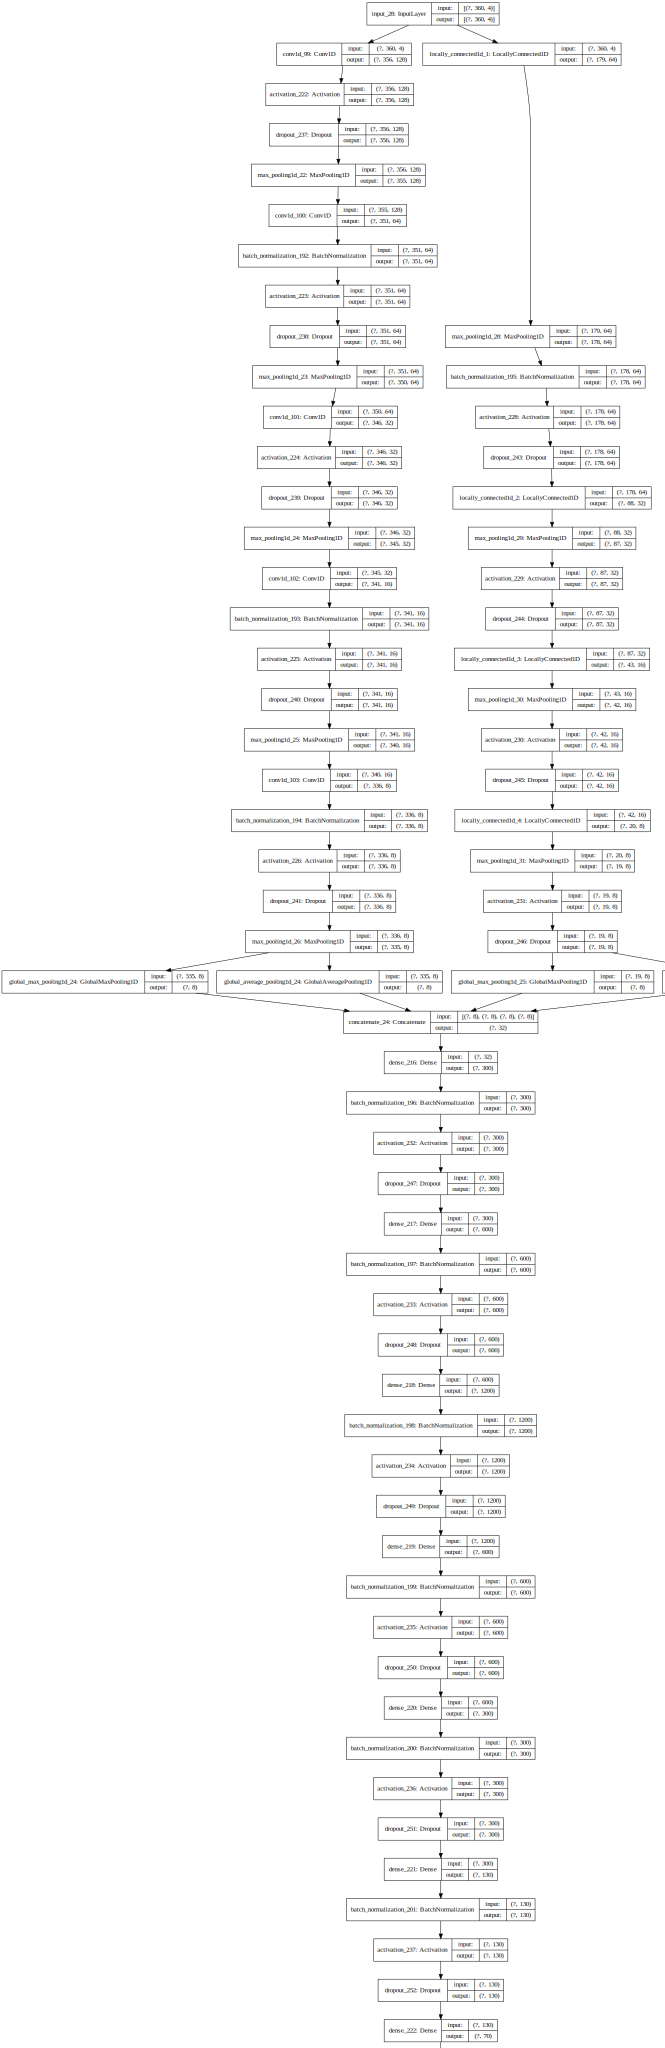

In [85]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [86]:
# from datetime import datetime
# import os

# from tensorflow.keras.callbacks import Callback
# import matplotlib.pyplot as plt
# import numpy as np
# from scikitplot.metrics import plot_confusion_matrix, plot_roc


# class PerformanceVisualizationCallback(Callback):
#     def __init__(self, model, validation_data, image_dir):
#         super().__init__()
#         self.model = model
#         self.validation_data = validation_data
        
#         os.makedirs(image_dir, exist_ok=True)
#         self.image_dir = image_dir

#     def on_epoch_end(self, epoch, logs={}):
#         y_pred = np.asarray(self.model.predict(self.validation_data[0]))
#         y_true = self.validation_data[1]             
#         y_pred_class = np.argmax(y_pred, axis=1)

#         # plot and save confusion matrix
#         fig, ax = plt.subplots(figsize=(16,12))
#         chart = plot_confusion_matrix(y_true, y_pred_class, ax=ax)
#         fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))
#         plt.display(chart)
#         plt.show()
        
#        # plot and save roc curve
#         fig, ax = plt.subplots(figsize=(16,12))
#         plot_roc(y_true, y_pred, ax=ax)
#         chart = fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))
#         plt.display(chart)
#         plt.show()
        
# logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=100) 
performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=v_dataset,
                      image_dir='performance_vizualizations')

callbacks_list = [checkpoint
#                   , early
                  , reduceLROnPlat
                  , tensorboard_callback
                  
                 ]


from IPython.display import clear_output
model.fit(train_dataset,
                      validation_data = v_dataset, 
#                       batch_size = 10,
                      epochs = 1000,
                      use_multiprocessing = True,
                      callbacks = callbacks_list)

# model.fit([train_X, train_X2], [train_y, train_y],
#                       validation_data = ([valid_X, valid_X2], [valid_y, valid_y]), 
#                       batch_size = batch_size,
#                       epochs = 500,
#                       callbacks = callbacks_list)

#clear_output()

W0613 23:44:42.706076  7492 callbacks.py:2207] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Epoch 1/1000
      2/Unknown - 0s 0s/step - loss: 1.3543 - accuracy: 0.30 - 8s 4s/step - loss: 1.2628 - accuracy: 0.3292

W0613 23:45:08.398110  7492 callbacks.py:307] Method (on_train_batch_end) is slow compared to the batch update (3.973660). Check your callbacks.


     19/Unknown - 8s 3s/step - loss: 1.1871 - accuracy: 0.39 - 8s 2s/step - loss: 1.1213 - accuracy: 0.45 - 8s 2s/step - loss: 1.0930 - accuracy: 0.48 - 8s 1s/step - loss: 1.0557 - accuracy: 0.51 - 8s 1s/step - loss: 1.0418 - accuracy: 0.53 - 8s 1s/step - loss: 1.0338 - accuracy: 0.54 - 9s 949ms/step - loss: 1.0279 - accuracy: 0.548 - 9s 862ms/step - loss: 1.0301 - accuracy: 0.545 - 9s 790ms/step - loss: 1.0215 - accuracy: 0.553 - 9s 730ms/step - loss: 1.0064 - accuracy: 0.567 - 9s 680ms/step - loss: 0.9832 - accuracy: 0.585 - 9s 636ms/step - loss: 0.9997 - accuracy: 0.578 - 9s 599ms/step - loss: 1.0298 - accuracy: 0.564 - 9s 566ms/step - loss: 1.0317 - accuracy: 0.564 - 9s 537ms/step - loss: 1.0361 - accuracy: 0.562 - 9s 511ms/step - loss: 1.0326 - accuracy: 0.564 - 9s 488ms/step - loss: 1.0307 - accuracy: 0.5644
Epoch 00001: val_loss improved from inf to 1.03998, saving model to stroke_lstm_model_weights.best.hdf5
19/19 [==============================] - 12s 611ms/step - loss: 1.0307

19/19 [==============================] - ETA: 0s - loss: 1.0138 - accuracy: 0.52 - ETA: 0s - loss: 1.0269 - accuracy: 0.51 - ETA: 0s - loss: 1.0175 - accuracy: 0.52 - ETA: 0s - loss: 0.9946 - accuracy: 0.55 - ETA: 0s - loss: 0.9853 - accuracy: 0.56 - ETA: 0s - loss: 0.9687 - accuracy: 0.58 - ETA: 0s - loss: 0.9619 - accuracy: 0.59 - ETA: 0s - loss: 0.9582 - accuracy: 0.59 - ETA: 0s - loss: 0.9608 - accuracy: 0.59 - ETA: 0s - loss: 0.9732 - accuracy: 0.58 - ETA: 0s - loss: 0.9617 - accuracy: 0.59 - ETA: 0s - loss: 0.9451 - accuracy: 0.60 - ETA: 0s - loss: 0.9247 - accuracy: 0.62 - ETA: 0s - loss: 0.9390 - accuracy: 0.61 - ETA: 0s - loss: 0.9602 - accuracy: 0.59 - ETA: 0s - loss: 0.9614 - accuracy: 0.59 - ETA: 0s - loss: 0.9655 - accuracy: 0.59 - ETA: 0s - loss: 0.9660 - accuracy: 0.59 - ETA: 0s - loss: 0.9677 - accuracy: 0.5891
Epoch 00008: val_loss did not improve from 1.03301
19/19 [==============================] - 2s 83ms/step - loss: 0.9677 - accuracy: 0.5891 - val_loss: 1.0371 - v

19/19 [==============================] - ETA: 0s - loss: 1.0231 - accuracy: 0.52 - ETA: 0s - loss: 1.0315 - accuracy: 0.51 - ETA: 0s - loss: 1.0268 - accuracy: 0.52 - ETA: 0s - loss: 1.0064 - accuracy: 0.55 - ETA: 0s - loss: 0.9966 - accuracy: 0.56 - ETA: 0s - loss: 0.9789 - accuracy: 0.58 - ETA: 0s - loss: 0.9710 - accuracy: 0.59 - ETA: 0s - loss: 0.9662 - accuracy: 0.59 - ETA: 0s - loss: 0.9662 - accuracy: 0.59 - ETA: 0s - loss: 0.9775 - accuracy: 0.58 - ETA: 0s - loss: 0.9648 - accuracy: 0.59 - ETA: 0s - loss: 0.9486 - accuracy: 0.60 - ETA: 0s - loss: 0.9280 - accuracy: 0.62 - ETA: 0s - loss: 0.9422 - accuracy: 0.61 - ETA: 0s - loss: 0.9634 - accuracy: 0.59 - ETA: 0s - loss: 0.9647 - accuracy: 0.59 - ETA: 0s - loss: 0.9687 - accuracy: 0.59 - ETA: 0s - loss: 0.9701 - accuracy: 0.58 - ETA: 0s - loss: 0.9731 - accuracy: 0.5869
Epoch 00015: val_loss did not improve from 1.02982
19/19 [==============================] - 2s 83ms/step - loss: 0.9731 - accuracy: 0.5869 - val_loss: 1.0370 - v

19/19 [==============================] - ETA: 0s - loss: 1.0195 - accuracy: 0.52 - ETA: 0s - loss: 1.0274 - accuracy: 0.51 - ETA: 0s - loss: 1.0225 - accuracy: 0.52 - ETA: 0s - loss: 0.9958 - accuracy: 0.55 - ETA: 0s - loss: 0.9864 - accuracy: 0.56 - ETA: 0s - loss: 0.9678 - accuracy: 0.58 - ETA: 0s - loss: 0.9613 - accuracy: 0.59 - ETA: 0s - loss: 0.9590 - accuracy: 0.59 - ETA: 0s - loss: 0.9606 - accuracy: 0.59 - ETA: 0s - loss: 0.9735 - accuracy: 0.58 - ETA: 0s - loss: 0.9615 - accuracy: 0.59 - ETA: 0s - loss: 0.9444 - accuracy: 0.60 - ETA: 0s - loss: 0.9239 - accuracy: 0.62 - ETA: 0s - loss: 0.9370 - accuracy: 0.61 - ETA: 0s - loss: 0.9559 - accuracy: 0.59 - ETA: 0s - loss: 0.9571 - accuracy: 0.59 - ETA: 0s - loss: 0.9612 - accuracy: 0.59 - ETA: 0s - loss: 0.9627 - accuracy: 0.59 - ETA: 0s - loss: 0.9645 - accuracy: 0.5892
Epoch 00022: val_loss improved from 1.02803 to 1.02736, saving model to stroke_lstm_model_weights.best.hdf5
19/19 [==============================] - 2s 87ms/step

19/19 [==============================] - ETA: 0s - loss: 1.0196 - accuracy: 0.51 - ETA: 0s - loss: 1.0215 - accuracy: 0.51 - ETA: 0s - loss: 1.0138 - accuracy: 0.52 - ETA: 0s - loss: 0.9873 - accuracy: 0.55 - ETA: 0s - loss: 0.9789 - accuracy: 0.56 - ETA: 0s - loss: 0.9607 - accuracy: 0.58 - ETA: 0s - loss: 0.9542 - accuracy: 0.58 - ETA: 0s - loss: 0.9513 - accuracy: 0.59 - ETA: 0s - loss: 0.9520 - accuracy: 0.59 - ETA: 0s - loss: 0.9632 - accuracy: 0.58 - ETA: 0s - loss: 0.9521 - accuracy: 0.59 - ETA: 0s - loss: 0.9360 - accuracy: 0.60 - ETA: 0s - loss: 0.9159 - accuracy: 0.62 - ETA: 0s - loss: 0.9303 - accuracy: 0.61 - ETA: 0s - loss: 0.9506 - accuracy: 0.59 - ETA: 0s - loss: 0.9529 - accuracy: 0.59 - ETA: 0s - loss: 0.9576 - accuracy: 0.59 - ETA: 0s - loss: 0.9593 - accuracy: 0.58 - ETA: 0s - loss: 0.9613 - accuracy: 0.5884
Epoch 00029: val_loss did not improve from 1.01635
19/19 [==============================] - 2s 83ms/step - loss: 0.9613 - accuracy: 0.5884 - val_loss: 1.0220 - v

Epoch 00036: val_loss did not improve from 1.01635
19/19 [==============================] - 2s 83ms/step - loss: 0.9596 - accuracy: 0.5898 - val_loss: 1.0228 - val_accuracy: 0.4979 - lr: 0.0900
Epoch 37/1000
19/19 [==============================] - ETA: 0s - loss: 1.0136 - accuracy: 0.52 - ETA: 0s - loss: 1.0189 - accuracy: 0.51 - ETA: 0s - loss: 1.0117 - accuracy: 0.52 - ETA: 0s - loss: 0.9888 - accuracy: 0.55 - ETA: 0s - loss: 0.9810 - accuracy: 0.56 - ETA: 0s - loss: 0.9636 - accuracy: 0.58 - ETA: 0s - loss: 0.9593 - accuracy: 0.59 - ETA: 0s - loss: 0.9578 - accuracy: 0.59 - ETA: 0s - loss: 0.9592 - accuracy: 0.59 - ETA: 0s - loss: 0.9704 - accuracy: 0.58 - ETA: 0s - loss: 0.9595 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.60 - ETA: 0s - loss: 0.9242 - accuracy: 0.62 - ETA: 0s - loss: 0.9364 - accuracy: 0.61 - ETA: 0s - loss: 0.9544 - accuracy: 0.59 - ETA: 0s - loss: 0.9559 - accuracy: 0.59 - ETA: 0s - loss: 0.9601 - accuracy: 0.59 - ETA: 0s - loss: 0.9607 - accuracy: 0.

19/19 [==============================] - ETA: 0s - loss: 1.0279 - accuracy: 0.52 - ETA: 0s - loss: 1.0282 - accuracy: 0.51 - ETA: 0s - loss: 1.0202 - accuracy: 0.52 - ETA: 0s - loss: 0.9953 - accuracy: 0.55 - ETA: 0s - loss: 0.9852 - accuracy: 0.56 - ETA: 0s - loss: 0.9674 - accuracy: 0.58 - ETA: 0s - loss: 0.9603 - accuracy: 0.58 - ETA: 0s - loss: 0.9566 - accuracy: 0.59 - ETA: 0s - loss: 0.9559 - accuracy: 0.59 - ETA: 0s - loss: 0.9666 - accuracy: 0.58 - ETA: 0s - loss: 0.9545 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.60 - ETA: 0s - loss: 0.9166 - accuracy: 0.62 - ETA: 0s - loss: 0.9325 - accuracy: 0.61 - ETA: 0s - loss: 0.9547 - accuracy: 0.59 - ETA: 0s - loss: 0.9562 - accuracy: 0.59 - ETA: 0s - loss: 0.9604 - accuracy: 0.58 - ETA: 0s - loss: 0.9607 - accuracy: 0.58 - ETA: 0s - loss: 0.9628 - accuracy: 0.5885
Epoch 00044: val_loss did not improve from 1.01564
19/19 [==============================] - 2s 83ms/step - loss: 0.9628 - accuracy: 0.5885 - val_loss: 1.0180 - v

Epoch 00051: val_loss did not improve from 1.01564

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.05760000348091126.
19/19 [==============================] - 2s 83ms/step - loss: 0.9621 - accuracy: 0.5897 - val_loss: 1.0171 - val_accuracy: 0.5064 - lr: 0.0720
Epoch 52/1000
19/19 [==============================] - ETA: 0s - loss: 1.0104 - accuracy: 0.51 - ETA: 0s - loss: 1.0143 - accuracy: 0.51 - ETA: 0s - loss: 1.0089 - accuracy: 0.52 - ETA: 0s - loss: 0.9925 - accuracy: 0.55 - ETA: 0s - loss: 0.9859 - accuracy: 0.56 - ETA: 0s - loss: 0.9702 - accuracy: 0.58 - ETA: 0s - loss: 0.9624 - accuracy: 0.59 - ETA: 0s - loss: 0.9580 - accuracy: 0.59 - ETA: 0s - loss: 0.9570 - accuracy: 0.59 - ETA: 0s - loss: 0.9679 - accuracy: 0.58 - ETA: 0s - loss: 0.9556 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.60 - ETA: 0s - loss: 0.9171 - accuracy: 0.62 - ETA: 0s - loss: 0.9338 - accuracy: 0.61 - ETA: 0s - loss: 0.9567 - accuracy: 0.59 - ETA: 0s - loss: 0.9582 - accuracy: 0.59 - 

19/19 [==============================] - ETA: 0s - loss: 1.0165 - accuracy: 0.52 - ETA: 0s - loss: 1.0250 - accuracy: 0.51 - ETA: 0s - loss: 1.0126 - accuracy: 0.52 - ETA: 0s - loss: 0.9852 - accuracy: 0.55 - ETA: 0s - loss: 0.9774 - accuracy: 0.56 - ETA: 0s - loss: 0.9639 - accuracy: 0.58 - ETA: 0s - loss: 0.9590 - accuracy: 0.59 - ETA: 0s - loss: 0.9566 - accuracy: 0.59 - ETA: 0s - loss: 0.9557 - accuracy: 0.59 - ETA: 0s - loss: 0.9626 - accuracy: 0.58 - ETA: 0s - loss: 0.9527 - accuracy: 0.59 - ETA: 0s - loss: 0.9390 - accuracy: 0.60 - ETA: 0s - loss: 0.9198 - accuracy: 0.62 - ETA: 0s - loss: 0.9330 - accuracy: 0.61 - ETA: 0s - loss: 0.9536 - accuracy: 0.59 - ETA: 0s - loss: 0.9554 - accuracy: 0.59 - ETA: 0s - loss: 0.9608 - accuracy: 0.59 - ETA: 0s - loss: 0.9608 - accuracy: 0.59 - ETA: 0s - loss: 0.9620 - accuracy: 0.5895
Epoch 00059: val_loss did not improve from 1.01564
19/19 [==============================] - 2s 83ms/step - loss: 0.9620 - accuracy: 0.5895 - val_loss: 1.0248 - v

19/19 [==============================] - ETA: 0s - loss: 1.0095 - accuracy: 0.52 - ETA: 0s - loss: 1.0140 - accuracy: 0.51 - ETA: 0s - loss: 1.0068 - accuracy: 0.52 - ETA: 0s - loss: 0.9852 - accuracy: 0.55 - ETA: 0s - loss: 0.9791 - accuracy: 0.56 - ETA: 0s - loss: 0.9649 - accuracy: 0.58 - ETA: 0s - loss: 0.9589 - accuracy: 0.59 - ETA: 0s - loss: 0.9552 - accuracy: 0.59 - ETA: 0s - loss: 0.9535 - accuracy: 0.59 - ETA: 0s - loss: 0.9629 - accuracy: 0.58 - ETA: 0s - loss: 0.9513 - accuracy: 0.59 - ETA: 0s - loss: 0.9355 - accuracy: 0.60 - ETA: 0s - loss: 0.9136 - accuracy: 0.62 - ETA: 0s - loss: 0.9322 - accuracy: 0.61 - ETA: 0s - loss: 0.9571 - accuracy: 0.59 - ETA: 0s - loss: 0.9591 - accuracy: 0.59 - ETA: 0s - loss: 0.9635 - accuracy: 0.59 - ETA: 0s - loss: 0.9634 - accuracy: 0.59 - ETA: 0s - loss: 0.9641 - accuracy: 0.5894
Epoch 00066: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9641 - accuracy: 0.5894 - val_loss: 1.0170 - v

19/19 [==============================] - ETA: 0s - loss: 1.0243 - accuracy: 0.51 - ETA: 0s - loss: 1.0288 - accuracy: 0.51 - ETA: 0s - loss: 1.0222 - accuracy: 0.52 - ETA: 0s - loss: 1.0007 - accuracy: 0.54 - ETA: 0s - loss: 0.9915 - accuracy: 0.56 - ETA: 0s - loss: 0.9726 - accuracy: 0.57 - ETA: 0s - loss: 0.9645 - accuracy: 0.58 - ETA: 0s - loss: 0.9598 - accuracy: 0.58 - ETA: 0s - loss: 0.9578 - accuracy: 0.58 - ETA: 0s - loss: 0.9677 - accuracy: 0.58 - ETA: 0s - loss: 0.9556 - accuracy: 0.59 - ETA: 0s - loss: 0.9397 - accuracy: 0.60 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9339 - accuracy: 0.60 - ETA: 0s - loss: 0.9553 - accuracy: 0.59 - ETA: 0s - loss: 0.9571 - accuracy: 0.59 - ETA: 0s - loss: 0.9619 - accuracy: 0.58 - ETA: 0s - loss: 0.9617 - accuracy: 0.58 - ETA: 0s - loss: 0.9624 - accuracy: 0.5877
Epoch 00073: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9624 - accuracy: 0.5877 - val_loss: 1.0172 - v

Epoch 00080: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9544 - accuracy: 0.5894 - val_loss: 1.0307 - val_accuracy: 0.4971 - lr: 0.0461
Epoch 81/1000
19/19 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.52 - ETA: 0s - loss: 1.0207 - accuracy: 0.51 - ETA: 0s - loss: 1.0093 - accuracy: 0.52 - ETA: 0s - loss: 0.9804 - accuracy: 0.55 - ETA: 0s - loss: 0.9716 - accuracy: 0.56 - ETA: 0s - loss: 0.9566 - accuracy: 0.58 - ETA: 0s - loss: 0.9512 - accuracy: 0.59 - ETA: 0s - loss: 0.9488 - accuracy: 0.59 - ETA: 0s - loss: 0.9479 - accuracy: 0.59 - ETA: 0s - loss: 0.9556 - accuracy: 0.58 - ETA: 0s - loss: 0.9466 - accuracy: 0.59 - ETA: 0s - loss: 0.9340 - accuracy: 0.60 - ETA: 0s - loss: 0.9157 - accuracy: 0.62 - ETA: 0s - loss: 0.9279 - accuracy: 0.61 - ETA: 0s - loss: 0.9462 - accuracy: 0.59 - ETA: 0s - loss: 0.9479 - accuracy: 0.59 - ETA: 0s - loss: 0.9529 - accuracy: 0.59 - ETA: 0s - loss: 0.9532 - accuracy: 0.

19/19 [==============================] - ETA: 0s - loss: 1.0121 - accuracy: 0.52 - ETA: 0s - loss: 1.0201 - accuracy: 0.51 - ETA: 0s - loss: 1.0089 - accuracy: 0.52 - ETA: 0s - loss: 0.9792 - accuracy: 0.55 - ETA: 0s - loss: 0.9699 - accuracy: 0.56 - ETA: 0s - loss: 0.9541 - accuracy: 0.58 - ETA: 0s - loss: 0.9485 - accuracy: 0.59 - ETA: 0s - loss: 0.9462 - accuracy: 0.59 - ETA: 0s - loss: 0.9453 - accuracy: 0.59 - ETA: 0s - loss: 0.9534 - accuracy: 0.58 - ETA: 0s - loss: 0.9442 - accuracy: 0.59 - ETA: 0s - loss: 0.9315 - accuracy: 0.60 - ETA: 0s - loss: 0.9131 - accuracy: 0.62 - ETA: 0s - loss: 0.9254 - accuracy: 0.61 - ETA: 0s - loss: 0.9435 - accuracy: 0.59 - ETA: 0s - loss: 0.9454 - accuracy: 0.59 - ETA: 0s - loss: 0.9503 - accuracy: 0.59 - ETA: 0s - loss: 0.9507 - accuracy: 0.59 - ETA: 0s - loss: 0.9522 - accuracy: 0.5892
Epoch 00088: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9522 - accuracy: 0.5892 - val_loss: 1.0284 - v

Epoch 00095: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9528 - accuracy: 0.5893 - val_loss: 1.0291 - val_accuracy: 0.4979 - lr: 0.0369
Epoch 96/1000
19/19 [==============================] - ETA: 0s - loss: 1.0108 - accuracy: 0.52 - ETA: 0s - loss: 1.0184 - accuracy: 0.51 - ETA: 0s - loss: 1.0073 - accuracy: 0.52 - ETA: 0s - loss: 0.9782 - accuracy: 0.55 - ETA: 0s - loss: 0.9693 - accuracy: 0.56 - ETA: 0s - loss: 0.9539 - accuracy: 0.58 - ETA: 0s - loss: 0.9487 - accuracy: 0.59 - ETA: 0s - loss: 0.9466 - accuracy: 0.59 - ETA: 0s - loss: 0.9457 - accuracy: 0.59 - ETA: 0s - loss: 0.9537 - accuracy: 0.58 - ETA: 0s - loss: 0.9446 - accuracy: 0.59 - ETA: 0s - loss: 0.9320 - accuracy: 0.60 - ETA: 0s - loss: 0.9135 - accuracy: 0.62 - ETA: 0s - loss: 0.9259 - accuracy: 0.61 - ETA: 0s - loss: 0.9440 - accuracy: 0.59 - ETA: 0s - loss: 0.9459 - accuracy: 0.59 - ETA: 0s - loss: 0.9509 - accuracy: 0.59 - ETA: 0s - loss: 0.9513 - accuracy: 0.

19/19 [==============================] - ETA: 0s - loss: 1.0094 - accuracy: 0.52 - ETA: 0s - loss: 1.0166 - accuracy: 0.51 - ETA: 0s - loss: 1.0058 - accuracy: 0.53 - ETA: 0s - loss: 0.9764 - accuracy: 0.55 - ETA: 0s - loss: 0.9675 - accuracy: 0.56 - ETA: 0s - loss: 0.9518 - accuracy: 0.58 - ETA: 0s - loss: 0.9467 - accuracy: 0.59 - ETA: 0s - loss: 0.9449 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.59 - ETA: 0s - loss: 0.9522 - accuracy: 0.58 - ETA: 0s - loss: 0.9432 - accuracy: 0.59 - ETA: 0s - loss: 0.9305 - accuracy: 0.60 - ETA: 0s - loss: 0.9120 - accuracy: 0.62 - ETA: 0s - loss: 0.9243 - accuracy: 0.61 - ETA: 0s - loss: 0.9421 - accuracy: 0.59 - ETA: 0s - loss: 0.9440 - accuracy: 0.59 - ETA: 0s - loss: 0.9491 - accuracy: 0.59 - ETA: 0s - loss: 0.9496 - accuracy: 0.59 - ETA: 0s - loss: 0.9511 - accuracy: 0.5890
Epoch 00103: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9511 - accuracy: 0.5890 - val_loss: 1.0276 - v

Epoch 00110: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9510 - accuracy: 0.5892 - val_loss: 1.0269 - val_accuracy: 0.4997 - lr: 0.0295
Epoch 111/1000
19/19 [==============================] - ETA: 0s - loss: 1.0085 - accuracy: 0.52 - ETA: 0s - loss: 1.0155 - accuracy: 0.51 - ETA: 0s - loss: 1.0048 - accuracy: 0.53 - ETA: 0s - loss: 0.9753 - accuracy: 0.55 - ETA: 0s - loss: 0.9666 - accuracy: 0.57 - ETA: 0s - loss: 0.9509 - accuracy: 0.58 - ETA: 0s - loss: 0.9460 - accuracy: 0.59 - ETA: 0s - loss: 0.9446 - accuracy: 0.59 - ETA: 0s - loss: 0.9437 - accuracy: 0.59 - ETA: 0s - loss: 0.9518 - accuracy: 0.58 - ETA: 0s - loss: 0.9429 - accuracy: 0.59 - ETA: 0s - loss: 0.9302 - accuracy: 0.60 - ETA: 0s - loss: 0.9115 - accuracy: 0.62 - ETA: 0s - loss: 0.9240 - accuracy: 0.61 - ETA: 0s - loss: 0.9418 - accuracy: 0.59 - ETA: 0s - loss: 0.9438 - accuracy: 0.59 - ETA: 0s - loss: 0.9489 - accuracy: 0.59 - ETA: 0s - loss: 0.9495 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0074 - accuracy: 0.52 - ETA: 0s - loss: 1.0141 - accuracy: 0.51 - ETA: 0s - loss: 1.0038 - accuracy: 0.53 - ETA: 0s - loss: 0.9738 - accuracy: 0.56 - ETA: 0s - loss: 0.9651 - accuracy: 0.57 - ETA: 0s - loss: 0.9490 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.59 - ETA: 0s - loss: 0.9429 - accuracy: 0.59 - ETA: 0s - loss: 0.9420 - accuracy: 0.59 - ETA: 0s - loss: 0.9504 - accuracy: 0.58 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9288 - accuracy: 0.60 - ETA: 0s - loss: 0.9102 - accuracy: 0.62 - ETA: 0s - loss: 0.9225 - accuracy: 0.61 - ETA: 0s - loss: 0.9399 - accuracy: 0.59 - ETA: 0s - loss: 0.9419 - accuracy: 0.59 - ETA: 0s - loss: 0.9470 - accuracy: 0.59 - ETA: 0s - loss: 0.9477 - accuracy: 0.59 - ETA: 0s - loss: 0.9492 - accuracy: 0.5893
Epoch 00118: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9492 - accuracy: 0.5893 - val_loss: 1.0250 - v

Epoch 00125: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9490 - accuracy: 0.5894 - val_loss: 1.0246 - val_accuracy: 0.4997 - lr: 0.0236
Epoch 126/1000
19/19 [==============================] - ETA: 0s - loss: 1.0070 - accuracy: 0.52 - ETA: 0s - loss: 1.0134 - accuracy: 0.51 - ETA: 0s - loss: 1.0033 - accuracy: 0.53 - ETA: 0s - loss: 0.9732 - accuracy: 0.55 - ETA: 0s - loss: 0.9645 - accuracy: 0.57 - ETA: 0s - loss: 0.9485 - accuracy: 0.58 - ETA: 0s - loss: 0.9437 - accuracy: 0.59 - ETA: 0s - loss: 0.9427 - accuracy: 0.59 - ETA: 0s - loss: 0.9418 - accuracy: 0.59 - ETA: 0s - loss: 0.9501 - accuracy: 0.58 - ETA: 0s - loss: 0.9413 - accuracy: 0.59 - ETA: 0s - loss: 0.9286 - accuracy: 0.60 - ETA: 0s - loss: 0.9099 - accuracy: 0.62 - ETA: 0s - loss: 0.9223 - accuracy: 0.61 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9417 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.59 - ETA: 0s - loss: 0.9476 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0063 - accuracy: 0.52 - ETA: 0s - loss: 1.0125 - accuracy: 0.51 - ETA: 0s - loss: 1.0027 - accuracy: 0.53 - ETA: 0s - loss: 0.9723 - accuracy: 0.55 - ETA: 0s - loss: 0.9637 - accuracy: 0.57 - ETA: 0s - loss: 0.9474 - accuracy: 0.58 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9417 - accuracy: 0.59 - ETA: 0s - loss: 0.9408 - accuracy: 0.59 - ETA: 0s - loss: 0.9493 - accuracy: 0.58 - ETA: 0s - loss: 0.9405 - accuracy: 0.59 - ETA: 0s - loss: 0.9278 - accuracy: 0.60 - ETA: 0s - loss: 0.9091 - accuracy: 0.62 - ETA: 0s - loss: 0.9214 - accuracy: 0.61 - ETA: 0s - loss: 0.9384 - accuracy: 0.59 - ETA: 0s - loss: 0.9405 - accuracy: 0.59 - ETA: 0s - loss: 0.9455 - accuracy: 0.59 - ETA: 0s - loss: 0.9464 - accuracy: 0.59 - ETA: 0s - loss: 0.9478 - accuracy: 0.5894
Epoch 00133: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9478 - accuracy: 0.5894 - val_loss: 1.0232 - v

Epoch 00140: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9478 - accuracy: 0.5894 - val_loss: 1.0231 - val_accuracy: 0.4997 - lr: 0.0189
Epoch 141/1000
19/19 [==============================] - ETA: 0s - loss: 1.0062 - accuracy: 0.52 - ETA: 0s - loss: 1.0123 - accuracy: 0.51 - ETA: 0s - loss: 1.0026 - accuracy: 0.53 - ETA: 0s - loss: 0.9721 - accuracy: 0.55 - ETA: 0s - loss: 0.9635 - accuracy: 0.57 - ETA: 0s - loss: 0.9472 - accuracy: 0.58 - ETA: 0s - loss: 0.9424 - accuracy: 0.59 - ETA: 0s - loss: 0.9416 - accuracy: 0.59 - ETA: 0s - loss: 0.9407 - accuracy: 0.59 - ETA: 0s - loss: 0.9492 - accuracy: 0.58 - ETA: 0s - loss: 0.9404 - accuracy: 0.59 - ETA: 0s - loss: 0.9277 - accuracy: 0.60 - ETA: 0s - loss: 0.9090 - accuracy: 0.62 - ETA: 0s - loss: 0.9213 - accuracy: 0.61 - ETA: 0s - loss: 0.9383 - accuracy: 0.59 - ETA: 0s - loss: 0.9404 - accuracy: 0.59 - ETA: 0s - loss: 0.9454 - accuracy: 0.59 - ETA: 0s - loss: 0.9463 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.52 - ETA: 0s - loss: 1.0116 - accuracy: 0.51 - ETA: 0s - loss: 1.0022 - accuracy: 0.53 - ETA: 0s - loss: 0.9715 - accuracy: 0.55 - ETA: 0s - loss: 0.9629 - accuracy: 0.57 - ETA: 0s - loss: 0.9465 - accuracy: 0.58 - ETA: 0s - loss: 0.9417 - accuracy: 0.59 - ETA: 0s - loss: 0.9410 - accuracy: 0.59 - ETA: 0s - loss: 0.9401 - accuracy: 0.59 - ETA: 0s - loss: 0.9487 - accuracy: 0.58 - ETA: 0s - loss: 0.9399 - accuracy: 0.59 - ETA: 0s - loss: 0.9271 - accuracy: 0.60 - ETA: 0s - loss: 0.9085 - accuracy: 0.62 - ETA: 0s - loss: 0.9207 - accuracy: 0.61 - ETA: 0s - loss: 0.9375 - accuracy: 0.59 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9446 - accuracy: 0.59 - ETA: 0s - loss: 0.9455 - accuracy: 0.59 - ETA: 0s - loss: 0.9470 - accuracy: 0.5896
Epoch 00148: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9470 - accuracy: 0.5896 - val_loss: 1.0221 - v

Epoch 00155: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9469 - accuracy: 0.5895 - val_loss: 1.0220 - val_accuracy: 0.4998 - lr: 0.0151
Epoch 156/1000
19/19 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.52 - ETA: 0s - loss: 1.0115 - accuracy: 0.51 - ETA: 0s - loss: 1.0022 - accuracy: 0.53 - ETA: 0s - loss: 0.9714 - accuracy: 0.55 - ETA: 0s - loss: 0.9628 - accuracy: 0.57 - ETA: 0s - loss: 0.9464 - accuracy: 0.58 - ETA: 0s - loss: 0.9416 - accuracy: 0.59 - ETA: 0s - loss: 0.9409 - accuracy: 0.59 - ETA: 0s - loss: 0.9400 - accuracy: 0.59 - ETA: 0s - loss: 0.9487 - accuracy: 0.58 - ETA: 0s - loss: 0.9398 - accuracy: 0.59 - ETA: 0s - loss: 0.9271 - accuracy: 0.60 - ETA: 0s - loss: 0.9084 - accuracy: 0.62 - ETA: 0s - loss: 0.9206 - accuracy: 0.61 - ETA: 0s - loss: 0.9374 - accuracy: 0.59 - ETA: 0s - loss: 0.9395 - accuracy: 0.59 - ETA: 0s - loss: 0.9446 - accuracy: 0.59 - ETA: 0s - loss: 0.9455 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.52 - ETA: 0s - loss: 1.0111 - accuracy: 0.51 - ETA: 0s - loss: 1.0019 - accuracy: 0.53 - ETA: 0s - loss: 0.9710 - accuracy: 0.55 - ETA: 0s - loss: 0.9624 - accuracy: 0.57 - ETA: 0s - loss: 0.9459 - accuracy: 0.58 - ETA: 0s - loss: 0.9411 - accuracy: 0.59 - ETA: 0s - loss: 0.9405 - accuracy: 0.59 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9483 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9266 - accuracy: 0.60 - ETA: 0s - loss: 0.9080 - accuracy: 0.62 - ETA: 0s - loss: 0.9202 - accuracy: 0.61 - ETA: 0s - loss: 0.9368 - accuracy: 0.59 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9439 - accuracy: 0.59 - ETA: 0s - loss: 0.9449 - accuracy: 0.59 - ETA: 0s - loss: 0.9463 - accuracy: 0.5895
Epoch 00163: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9463 - accuracy: 0.5895 - val_loss: 1.0213 - v

Epoch 00170: val_loss did not improve from 1.01430

Epoch 00170: ReduceLROnPlateau reducing learning rate to 0.009663675725460053.
19/19 [==============================] - 2s 83ms/step - loss: 0.9463 - accuracy: 0.5894 - val_loss: 1.0212 - val_accuracy: 0.4997 - lr: 0.0121
Epoch 171/1000
19/19 [==============================] - ETA: 0s - loss: 1.0054 - accuracy: 0.52 - ETA: 0s - loss: 1.0111 - accuracy: 0.51 - ETA: 0s - loss: 1.0020 - accuracy: 0.53 - ETA: 0s - loss: 0.9709 - accuracy: 0.55 - ETA: 0s - loss: 0.9623 - accuracy: 0.57 - ETA: 0s - loss: 0.9456 - accuracy: 0.58 - ETA: 0s - loss: 0.9408 - accuracy: 0.59 - ETA: 0s - loss: 0.9402 - accuracy: 0.59 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9480 - accuracy: 0.58 - ETA: 0s - loss: 0.9392 - accuracy: 0.59 - ETA: 0s - loss: 0.9263 - accuracy: 0.60 - ETA: 0s - loss: 0.9077 - accuracy: 0.62 - ETA: 0s - loss: 0.9198 - accuracy: 0.61 - ETA: 0s - loss: 0.9363 - accuracy: 0.59 - ETA: 0s - loss: 0.9384 - accuracy: 0.59 

19/19 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.52 - ETA: 0s - loss: 1.0107 - accuracy: 0.51 - ETA: 0s - loss: 1.0017 - accuracy: 0.53 - ETA: 0s - loss: 0.9706 - accuracy: 0.55 - ETA: 0s - loss: 0.9621 - accuracy: 0.57 - ETA: 0s - loss: 0.9455 - accuracy: 0.58 - ETA: 0s - loss: 0.9407 - accuracy: 0.59 - ETA: 0s - loss: 0.9401 - accuracy: 0.59 - ETA: 0s - loss: 0.9392 - accuracy: 0.59 - ETA: 0s - loss: 0.9480 - accuracy: 0.58 - ETA: 0s - loss: 0.9391 - accuracy: 0.59 - ETA: 0s - loss: 0.9263 - accuracy: 0.60 - ETA: 0s - loss: 0.9076 - accuracy: 0.62 - ETA: 0s - loss: 0.9198 - accuracy: 0.61 - ETA: 0s - loss: 0.9363 - accuracy: 0.59 - ETA: 0s - loss: 0.9384 - accuracy: 0.59 - ETA: 0s - loss: 0.9434 - accuracy: 0.59 - ETA: 0s - loss: 0.9444 - accuracy: 0.59 - ETA: 0s - loss: 0.9459 - accuracy: 0.5894
Epoch 00178: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9459 - accuracy: 0.5894 - val_loss: 1.0206 - v

19/19 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.52 - ETA: 0s - loss: 1.0107 - accuracy: 0.51 - ETA: 0s - loss: 1.0018 - accuracy: 0.53 - ETA: 0s - loss: 0.9706 - accuracy: 0.55 - ETA: 0s - loss: 0.9620 - accuracy: 0.57 - ETA: 0s - loss: 0.9453 - accuracy: 0.58 - ETA: 0s - loss: 0.9405 - accuracy: 0.59 - ETA: 0s - loss: 0.9399 - accuracy: 0.59 - ETA: 0s - loss: 0.9390 - accuracy: 0.59 - ETA: 0s - loss: 0.9478 - accuracy: 0.58 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9260 - accuracy: 0.60 - ETA: 0s - loss: 0.9074 - accuracy: 0.62 - ETA: 0s - loss: 0.9195 - accuracy: 0.61 - ETA: 0s - loss: 0.9359 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9430 - accuracy: 0.59 - ETA: 0s - loss: 0.9440 - accuracy: 0.59 - ETA: 0s - loss: 0.9455 - accuracy: 0.5893
Epoch 00185: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9455 - accuracy: 0.5893 - val_loss: 1.0201 - v

Epoch 00192: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9455 - accuracy: 0.5892 - val_loss: 1.0201 - val_accuracy: 0.5000 - lr: 0.0077
Epoch 193/1000
19/19 [==============================] - ETA: 0s - loss: 1.0049 - accuracy: 0.52 - ETA: 0s - loss: 1.0104 - accuracy: 0.51 - ETA: 0s - loss: 1.0015 - accuracy: 0.53 - ETA: 0s - loss: 0.9704 - accuracy: 0.55 - ETA: 0s - loss: 0.9619 - accuracy: 0.57 - ETA: 0s - loss: 0.9452 - accuracy: 0.58 - ETA: 0s - loss: 0.9404 - accuracy: 0.59 - ETA: 0s - loss: 0.9398 - accuracy: 0.59 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9477 - accuracy: 0.58 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9260 - accuracy: 0.60 - ETA: 0s - loss: 0.9073 - accuracy: 0.62 - ETA: 0s - loss: 0.9194 - accuracy: 0.61 - ETA: 0s - loss: 0.9359 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9430 - accuracy: 0.59 - ETA: 0s - loss: 0.9440 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0048 - accuracy: 0.52 - ETA: 0s - loss: 1.0101 - accuracy: 0.51 - ETA: 0s - loss: 1.0014 - accuracy: 0.53 - ETA: 0s - loss: 0.9702 - accuracy: 0.55 - ETA: 0s - loss: 0.9617 - accuracy: 0.57 - ETA: 0s - loss: 0.9450 - accuracy: 0.58 - ETA: 0s - loss: 0.9402 - accuracy: 0.59 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9475 - accuracy: 0.58 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9258 - accuracy: 0.60 - ETA: 0s - loss: 0.9071 - accuracy: 0.62 - ETA: 0s - loss: 0.9192 - accuracy: 0.61 - ETA: 0s - loss: 0.9356 - accuracy: 0.59 - ETA: 0s - loss: 0.9378 - accuracy: 0.59 - ETA: 0s - loss: 0.9427 - accuracy: 0.59 - ETA: 0s - loss: 0.9437 - accuracy: 0.59 - ETA: 0s - loss: 0.9452 - accuracy: 0.5892
Epoch 00200: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9452 - accuracy: 0.5892 - val_loss: 1.0196 - v

Epoch 00207: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9452 - accuracy: 0.5892 - val_loss: 1.0196 - val_accuracy: 0.5000 - lr: 0.0062
Epoch 208/1000
19/19 [==============================] - ETA: 0s - loss: 1.0048 - accuracy: 0.52 - ETA: 0s - loss: 1.0101 - accuracy: 0.51 - ETA: 0s - loss: 1.0014 - accuracy: 0.53 - ETA: 0s - loss: 0.9702 - accuracy: 0.55 - ETA: 0s - loss: 0.9617 - accuracy: 0.57 - ETA: 0s - loss: 0.9449 - accuracy: 0.58 - ETA: 0s - loss: 0.9402 - accuracy: 0.59 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9475 - accuracy: 0.58 - ETA: 0s - loss: 0.9386 - accuracy: 0.59 - ETA: 0s - loss: 0.9257 - accuracy: 0.60 - ETA: 0s - loss: 0.9071 - accuracy: 0.62 - ETA: 0s - loss: 0.9192 - accuracy: 0.61 - ETA: 0s - loss: 0.9355 - accuracy: 0.59 - ETA: 0s - loss: 0.9377 - accuracy: 0.59 - ETA: 0s - loss: 0.9427 - accuracy: 0.59 - ETA: 0s - loss: 0.9437 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0046 - accuracy: 0.52 - ETA: 0s - loss: 1.0099 - accuracy: 0.51 - ETA: 0s - loss: 1.0013 - accuracy: 0.53 - ETA: 0s - loss: 0.9700 - accuracy: 0.55 - ETA: 0s - loss: 0.9615 - accuracy: 0.57 - ETA: 0s - loss: 0.9447 - accuracy: 0.58 - ETA: 0s - loss: 0.9400 - accuracy: 0.59 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9385 - accuracy: 0.59 - ETA: 0s - loss: 0.9474 - accuracy: 0.58 - ETA: 0s - loss: 0.9385 - accuracy: 0.59 - ETA: 0s - loss: 0.9256 - accuracy: 0.60 - ETA: 0s - loss: 0.9069 - accuracy: 0.62 - ETA: 0s - loss: 0.9190 - accuracy: 0.61 - ETA: 0s - loss: 0.9353 - accuracy: 0.59 - ETA: 0s - loss: 0.9375 - accuracy: 0.59 - ETA: 0s - loss: 0.9424 - accuracy: 0.59 - ETA: 0s - loss: 0.9434 - accuracy: 0.59 - ETA: 0s - loss: 0.9450 - accuracy: 0.5891
Epoch 00215: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9450 - accuracy: 0.5891 - val_loss: 1.0193 - v

Epoch 00222: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9450 - accuracy: 0.5891 - val_loss: 1.0193 - val_accuracy: 0.5002 - lr: 0.0049
Epoch 223/1000
19/19 [==============================] - ETA: 0s - loss: 1.0047 - accuracy: 0.52 - ETA: 0s - loss: 1.0099 - accuracy: 0.51 - ETA: 0s - loss: 1.0013 - accuracy: 0.53 - ETA: 0s - loss: 0.9700 - accuracy: 0.55 - ETA: 0s - loss: 0.9615 - accuracy: 0.57 - ETA: 0s - loss: 0.9447 - accuracy: 0.58 - ETA: 0s - loss: 0.9400 - accuracy: 0.59 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9385 - accuracy: 0.59 - ETA: 0s - loss: 0.9473 - accuracy: 0.58 - ETA: 0s - loss: 0.9385 - accuracy: 0.59 - ETA: 0s - loss: 0.9255 - accuracy: 0.60 - ETA: 0s - loss: 0.9069 - accuracy: 0.62 - ETA: 0s - loss: 0.9190 - accuracy: 0.61 - ETA: 0s - loss: 0.9353 - accuracy: 0.59 - ETA: 0s - loss: 0.9375 - accuracy: 0.59 - ETA: 0s - loss: 0.9424 - accuracy: 0.59 - ETA: 0s - loss: 0.9434 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0046 - accuracy: 0.52 - ETA: 0s - loss: 1.0098 - accuracy: 0.51 - ETA: 0s - loss: 1.0012 - accuracy: 0.53 - ETA: 0s - loss: 0.9699 - accuracy: 0.55 - ETA: 0s - loss: 0.9614 - accuracy: 0.57 - ETA: 0s - loss: 0.9446 - accuracy: 0.58 - ETA: 0s - loss: 0.9399 - accuracy: 0.59 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9384 - accuracy: 0.59 - ETA: 0s - loss: 0.9472 - accuracy: 0.58 - ETA: 0s - loss: 0.9383 - accuracy: 0.59 - ETA: 0s - loss: 0.9254 - accuracy: 0.60 - ETA: 0s - loss: 0.9068 - accuracy: 0.62 - ETA: 0s - loss: 0.9188 - accuracy: 0.61 - ETA: 0s - loss: 0.9351 - accuracy: 0.59 - ETA: 0s - loss: 0.9373 - accuracy: 0.59 - ETA: 0s - loss: 0.9422 - accuracy: 0.59 - ETA: 0s - loss: 0.9432 - accuracy: 0.59 - ETA: 0s - loss: 0.9448 - accuracy: 0.5890
Epoch 00230: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9448 - accuracy: 0.5890 - val_loss: 1.0190 - v

Epoch 00237: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9448 - accuracy: 0.5889 - val_loss: 1.0190 - val_accuracy: 0.5002 - lr: 0.0040
Epoch 238/1000
19/19 [==============================] - ETA: 0s - loss: 1.0046 - accuracy: 0.52 - ETA: 0s - loss: 1.0098 - accuracy: 0.51 - ETA: 0s - loss: 1.0012 - accuracy: 0.53 - ETA: 0s - loss: 0.9699 - accuracy: 0.55 - ETA: 0s - loss: 0.9614 - accuracy: 0.57 - ETA: 0s - loss: 0.9446 - accuracy: 0.58 - ETA: 0s - loss: 0.9399 - accuracy: 0.59 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9384 - accuracy: 0.59 - ETA: 0s - loss: 0.9472 - accuracy: 0.58 - ETA: 0s - loss: 0.9383 - accuracy: 0.59 - ETA: 0s - loss: 0.9254 - accuracy: 0.60 - ETA: 0s - loss: 0.9067 - accuracy: 0.62 - ETA: 0s - loss: 0.9188 - accuracy: 0.61 - ETA: 0s - loss: 0.9351 - accuracy: 0.59 - ETA: 0s - loss: 0.9373 - accuracy: 0.59 - ETA: 0s - loss: 0.9422 - accuracy: 0.59 - ETA: 0s - loss: 0.9432 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0045 - accuracy: 0.52 - ETA: 0s - loss: 1.0097 - accuracy: 0.51 - ETA: 0s - loss: 1.0012 - accuracy: 0.53 - ETA: 0s - loss: 0.9698 - accuracy: 0.55 - ETA: 0s - loss: 0.9613 - accuracy: 0.57 - ETA: 0s - loss: 0.9445 - accuracy: 0.58 - ETA: 0s - loss: 0.9398 - accuracy: 0.59 - ETA: 0s - loss: 0.9392 - accuracy: 0.59 - ETA: 0s - loss: 0.9383 - accuracy: 0.59 - ETA: 0s - loss: 0.9471 - accuracy: 0.58 - ETA: 0s - loss: 0.9382 - accuracy: 0.59 - ETA: 0s - loss: 0.9253 - accuracy: 0.60 - ETA: 0s - loss: 0.9066 - accuracy: 0.62 - ETA: 0s - loss: 0.9187 - accuracy: 0.61 - ETA: 0s - loss: 0.9349 - accuracy: 0.59 - ETA: 0s - loss: 0.9371 - accuracy: 0.59 - ETA: 0s - loss: 0.9420 - accuracy: 0.59 - ETA: 0s - loss: 0.9431 - accuracy: 0.59 - ETA: 0s - loss: 0.9446 - accuracy: 0.5889
Epoch 00245: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9446 - accuracy: 0.5889 - val_loss: 1.0188 - v

Epoch 00252: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9446 - accuracy: 0.5889 - val_loss: 1.0188 - val_accuracy: 0.5002 - lr: 0.0032
Epoch 253/1000
19/19 [==============================] - ETA: 0s - loss: 1.0045 - accuracy: 0.52 - ETA: 0s - loss: 1.0097 - accuracy: 0.51 - ETA: 0s - loss: 1.0012 - accuracy: 0.53 - ETA: 0s - loss: 0.9698 - accuracy: 0.55 - ETA: 0s - loss: 0.9613 - accuracy: 0.57 - ETA: 0s - loss: 0.9445 - accuracy: 0.58 - ETA: 0s - loss: 0.9397 - accuracy: 0.59 - ETA: 0s - loss: 0.9391 - accuracy: 0.59 - ETA: 0s - loss: 0.9383 - accuracy: 0.59 - ETA: 0s - loss: 0.9471 - accuracy: 0.58 - ETA: 0s - loss: 0.9382 - accuracy: 0.59 - ETA: 0s - loss: 0.9253 - accuracy: 0.60 - ETA: 0s - loss: 0.9066 - accuracy: 0.62 - ETA: 0s - loss: 0.9187 - accuracy: 0.61 - ETA: 0s - loss: 0.9349 - accuracy: 0.59 - ETA: 0s - loss: 0.9371 - accuracy: 0.59 - ETA: 0s - loss: 0.9420 - accuracy: 0.59 - ETA: 0s - loss: 0.9431 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.52 - ETA: 0s - loss: 1.0096 - accuracy: 0.51 - ETA: 0s - loss: 1.0011 - accuracy: 0.53 - ETA: 0s - loss: 0.9698 - accuracy: 0.55 - ETA: 0s - loss: 0.9613 - accuracy: 0.57 - ETA: 0s - loss: 0.9444 - accuracy: 0.58 - ETA: 0s - loss: 0.9397 - accuracy: 0.59 - ETA: 0s - loss: 0.9391 - accuracy: 0.59 - ETA: 0s - loss: 0.9382 - accuracy: 0.59 - ETA: 0s - loss: 0.9471 - accuracy: 0.58 - ETA: 0s - loss: 0.9382 - accuracy: 0.59 - ETA: 0s - loss: 0.9252 - accuracy: 0.60 - ETA: 0s - loss: 0.9065 - accuracy: 0.62 - ETA: 0s - loss: 0.9186 - accuracy: 0.61 - ETA: 0s - loss: 0.9348 - accuracy: 0.59 - ETA: 0s - loss: 0.9370 - accuracy: 0.59 - ETA: 0s - loss: 0.9419 - accuracy: 0.59 - ETA: 0s - loss: 0.9429 - accuracy: 0.59 - ETA: 0s - loss: 0.9445 - accuracy: 0.5889
Epoch 00260: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9445 - accuracy: 0.5889 - val_loss: 1.0186 - v

Epoch 00267: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9445 - accuracy: 0.5887 - val_loss: 1.0186 - val_accuracy: 0.5002 - lr: 0.0025
Epoch 268/1000
19/19 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.52 - ETA: 0s - loss: 1.0096 - accuracy: 0.51 - ETA: 0s - loss: 1.0011 - accuracy: 0.53 - ETA: 0s - loss: 0.9698 - accuracy: 0.55 - ETA: 0s - loss: 0.9612 - accuracy: 0.56 - ETA: 0s - loss: 0.9444 - accuracy: 0.58 - ETA: 0s - loss: 0.9397 - accuracy: 0.59 - ETA: 0s - loss: 0.9391 - accuracy: 0.59 - ETA: 0s - loss: 0.9382 - accuracy: 0.59 - ETA: 0s - loss: 0.9471 - accuracy: 0.58 - ETA: 0s - loss: 0.9382 - accuracy: 0.59 - ETA: 0s - loss: 0.9252 - accuracy: 0.60 - ETA: 0s - loss: 0.9065 - accuracy: 0.62 - ETA: 0s - loss: 0.9186 - accuracy: 0.61 - ETA: 0s - loss: 0.9348 - accuracy: 0.59 - ETA: 0s - loss: 0.9370 - accuracy: 0.59 - ETA: 0s - loss: 0.9419 - accuracy: 0.59 - ETA: 0s - loss: 0.9429 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.52 - ETA: 0s - loss: 1.0095 - accuracy: 0.51 - ETA: 0s - loss: 1.0011 - accuracy: 0.53 - ETA: 0s - loss: 0.9697 - accuracy: 0.55 - ETA: 0s - loss: 0.9612 - accuracy: 0.56 - ETA: 0s - loss: 0.9443 - accuracy: 0.58 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9390 - accuracy: 0.59 - ETA: 0s - loss: 0.9381 - accuracy: 0.59 - ETA: 0s - loss: 0.9470 - accuracy: 0.58 - ETA: 0s - loss: 0.9381 - accuracy: 0.59 - ETA: 0s - loss: 0.9251 - accuracy: 0.60 - ETA: 0s - loss: 0.9065 - accuracy: 0.62 - ETA: 0s - loss: 0.9185 - accuracy: 0.61 - ETA: 0s - loss: 0.9347 - accuracy: 0.59 - ETA: 0s - loss: 0.9369 - accuracy: 0.59 - ETA: 0s - loss: 0.9418 - accuracy: 0.59 - ETA: 0s - loss: 0.9428 - accuracy: 0.59 - ETA: 0s - loss: 0.9444 - accuracy: 0.5888
Epoch 00275: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9444 - accuracy: 0.5888 - val_loss: 1.0185 - v

Epoch 00282: val_loss did not improve from 1.01430

Epoch 00282: ReduceLROnPlateau reducing learning rate to 0.0016212956979870796.
19/19 [==============================] - 2s 83ms/step - loss: 0.9444 - accuracy: 0.5888 - val_loss: 1.0185 - val_accuracy: 0.5002 - lr: 0.0020
Epoch 283/1000
19/19 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.52 - ETA: 0s - loss: 1.0095 - accuracy: 0.51 - ETA: 0s - loss: 1.0011 - accuracy: 0.53 - ETA: 0s - loss: 0.9697 - accuracy: 0.55 - ETA: 0s - loss: 0.9612 - accuracy: 0.56 - ETA: 0s - loss: 0.9443 - accuracy: 0.58 - ETA: 0s - loss: 0.9396 - accuracy: 0.59 - ETA: 0s - loss: 0.9390 - accuracy: 0.59 - ETA: 0s - loss: 0.9381 - accuracy: 0.59 - ETA: 0s - loss: 0.9470 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9251 - accuracy: 0.60 - ETA: 0s - loss: 0.9064 - accuracy: 0.62 - ETA: 0s - loss: 0.9184 - accuracy: 0.61 - ETA: 0s - loss: 0.9346 - accuracy: 0.59 - ETA: 0s - loss: 0.9368 - accuracy: 0.59

19/19 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.52 - ETA: 0s - loss: 1.0095 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9697 - accuracy: 0.55 - ETA: 0s - loss: 0.9612 - accuracy: 0.56 - ETA: 0s - loss: 0.9442 - accuracy: 0.58 - ETA: 0s - loss: 0.9395 - accuracy: 0.59 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9381 - accuracy: 0.59 - ETA: 0s - loss: 0.9470 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9251 - accuracy: 0.60 - ETA: 0s - loss: 0.9064 - accuracy: 0.62 - ETA: 0s - loss: 0.9185 - accuracy: 0.61 - ETA: 0s - loss: 0.9346 - accuracy: 0.59 - ETA: 0s - loss: 0.9368 - accuracy: 0.59 - ETA: 0s - loss: 0.9417 - accuracy: 0.59 - ETA: 0s - loss: 0.9428 - accuracy: 0.59 - ETA: 0s - loss: 0.9444 - accuracy: 0.5888
Epoch 00290: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9444 - accuracy: 0.5888 - val_loss: 1.0184 - v

19/19 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.52 - ETA: 0s - loss: 1.0095 - accuracy: 0.51 - ETA: 0s - loss: 1.0011 - accuracy: 0.53 - ETA: 0s - loss: 0.9696 - accuracy: 0.55 - ETA: 0s - loss: 0.9611 - accuracy: 0.56 - ETA: 0s - loss: 0.9442 - accuracy: 0.58 - ETA: 0s - loss: 0.9395 - accuracy: 0.59 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9469 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9250 - accuracy: 0.60 - ETA: 0s - loss: 0.9063 - accuracy: 0.62 - ETA: 0s - loss: 0.9184 - accuracy: 0.61 - ETA: 0s - loss: 0.9345 - accuracy: 0.59 - ETA: 0s - loss: 0.9368 - accuracy: 0.59 - ETA: 0s - loss: 0.9416 - accuracy: 0.59 - ETA: 0s - loss: 0.9427 - accuracy: 0.59 - ETA: 0s - loss: 0.9443 - accuracy: 0.5887
Epoch 00297: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9443 - accuracy: 0.5887 - val_loss: 1.0183 - v

Epoch 00304: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9443 - accuracy: 0.5887 - val_loss: 1.0183 - val_accuracy: 0.5002 - lr: 0.0013
Epoch 305/1000
19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0094 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9696 - accuracy: 0.55 - ETA: 0s - loss: 0.9611 - accuracy: 0.56 - ETA: 0s - loss: 0.9442 - accuracy: 0.58 - ETA: 0s - loss: 0.9395 - accuracy: 0.59 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9469 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9250 - accuracy: 0.60 - ETA: 0s - loss: 0.9064 - accuracy: 0.62 - ETA: 0s - loss: 0.9184 - accuracy: 0.61 - ETA: 0s - loss: 0.9345 - accuracy: 0.59 - ETA: 0s - loss: 0.9368 - accuracy: 0.59 - ETA: 0s - loss: 0.9416 - accuracy: 0.59 - ETA: 0s - loss: 0.9427 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0094 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9696 - accuracy: 0.55 - ETA: 0s - loss: 0.9611 - accuracy: 0.56 - ETA: 0s - loss: 0.9442 - accuracy: 0.58 - ETA: 0s - loss: 0.9395 - accuracy: 0.59 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9469 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9250 - accuracy: 0.60 - ETA: 0s - loss: 0.9063 - accuracy: 0.62 - ETA: 0s - loss: 0.9184 - accuracy: 0.61 - ETA: 0s - loss: 0.9345 - accuracy: 0.59 - ETA: 0s - loss: 0.9367 - accuracy: 0.59 - ETA: 0s - loss: 0.9416 - accuracy: 0.59 - ETA: 0s - loss: 0.9427 - accuracy: 0.59 - ETA: 0s - loss: 0.9443 - accuracy: 0.5887
Epoch 00312: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9443 - accuracy: 0.5887 - val_loss: 1.0182 - v

Epoch 00319: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9443 - accuracy: 0.5887 - val_loss: 1.0182 - val_accuracy: 0.5002 - lr: 0.0010
Epoch 320/1000
19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0094 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9696 - accuracy: 0.55 - ETA: 0s - loss: 0.9611 - accuracy: 0.56 - ETA: 0s - loss: 0.9442 - accuracy: 0.58 - ETA: 0s - loss: 0.9395 - accuracy: 0.59 - ETA: 0s - loss: 0.9389 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9469 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9250 - accuracy: 0.60 - ETA: 0s - loss: 0.9063 - accuracy: 0.62 - ETA: 0s - loss: 0.9184 - accuracy: 0.61 - ETA: 0s - loss: 0.9345 - accuracy: 0.59 - ETA: 0s - loss: 0.9367 - accuracy: 0.59 - ETA: 0s - loss: 0.9416 - accuracy: 0.59 - ETA: 0s - loss: 0.9427 - accuracy: 0

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0094 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9696 - accuracy: 0.55 - ETA: 0s - loss: 0.9611 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9469 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9250 - accuracy: 0.60 - ETA: 0s - loss: 0.9063 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9344 - accuracy: 0.59 - ETA: 0s - loss: 0.9367 - accuracy: 0.59 - ETA: 0s - loss: 0.9416 - accuracy: 0.59 - ETA: 0s - loss: 0.9426 - accuracy: 0.59 - ETA: 0s - loss: 0.9442 - accuracy: 0.5887
Epoch 00327: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9442 - accuracy: 0.5887 - val_loss: 1.0182 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9696 - accuracy: 0.55 - ETA: 0s - loss: 0.9611 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9469 - accuracy: 0.58 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9250 - accuracy: 0.60 - ETA: 0s - loss: 0.9063 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9344 - accuracy: 0.59 - ETA: 0s - loss: 0.9367 - accuracy: 0.59 - ETA: 0s - loss: 0.9416 - accuracy: 0.59 - ETA: 0s - loss: 0.9426 - accuracy: 0.59 - ETA: 0s - loss: 0.9442 - accuracy: 0.5887
Epoch 00334: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9442 - accuracy: 0.5887 - val_loss: 1.0182 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9696 - accuracy: 0.55 - ETA: 0s - loss: 0.9611 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9469 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9063 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9344 - accuracy: 0.59 - ETA: 0s - loss: 0.9367 - accuracy: 0.59 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9426 - accuracy: 0.59 - ETA: 0s - loss: 0.9442 - accuracy: 0.5887
Epoch 00341: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9442 - accuracy: 0.5887 - val_loss: 1.0181 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9380 - accuracy: 0.59 - ETA: 0s - loss: 0.9469 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9063 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9344 - accuracy: 0.59 - ETA: 0s - loss: 0.9367 - accuracy: 0.59 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9426 - accuracy: 0.59 - ETA: 0s - loss: 0.9442 - accuracy: 0.5887
Epoch 00348: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9442 - accuracy: 0.5887 - val_loss: 1.0181 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9344 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9426 - accuracy: 0.58 - ETA: 0s - loss: 0.9442 - accuracy: 0.5887
Epoch 00355: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9442 - accuracy: 0.5887 - val_loss: 1.0181 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9344 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9426 - accuracy: 0.58 - ETA: 0s - loss: 0.9442 - accuracy: 0.5887
Epoch 00362: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9442 - accuracy: 0.5887 - val_loss: 1.0181 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0010 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9442 - accuracy: 0.5887
Epoch 00369: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9442 - accuracy: 0.5887 - val_loss: 1.0181 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9442 - accuracy: 0.5887
Epoch 00376: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9442 - accuracy: 0.5887 - val_loss: 1.0181 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00383: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9183 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9415 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00390: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00397: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00404: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00411: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00418: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00425: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0093 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00432: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00439: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9441 - accuracy: 0.58 - ETA: 0s - loss: 0.9394 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00446: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00453: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00460: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00467: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00474: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00481: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00488: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00495: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00502: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00509: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00516: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00523: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00530: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 84ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00537: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00544: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00551: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00558: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00565: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00572: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00579: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00586: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9388 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00593: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00600: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9249 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00607: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00614: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00621: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00628: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00635: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00642: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00649: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00656: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00663: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00670: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00677: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00684: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00691: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00698: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00705: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00712: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00719: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00726: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00733: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00740: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00747: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00754: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00761: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00768: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00775: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00782: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00789: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00796: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00803: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00810: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00817: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00824: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00831: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00838: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00845: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.58 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00852: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0180 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00859: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00866: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00873: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00880: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00887: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00894: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00901: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9365 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00908: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

19/19 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.52 - ETA: 0s - loss: 1.0092 - accuracy: 0.51 - ETA: 0s - loss: 1.0009 - accuracy: 0.53 - ETA: 0s - loss: 0.9695 - accuracy: 0.55 - ETA: 0s - loss: 0.9610 - accuracy: 0.56 - ETA: 0s - loss: 0.9440 - accuracy: 0.58 - ETA: 0s - loss: 0.9393 - accuracy: 0.59 - ETA: 0s - loss: 0.9387 - accuracy: 0.59 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9468 - accuracy: 0.58 - ETA: 0s - loss: 0.9379 - accuracy: 0.59 - ETA: 0s - loss: 0.9248 - accuracy: 0.60 - ETA: 0s - loss: 0.9062 - accuracy: 0.62 - ETA: 0s - loss: 0.9182 - accuracy: 0.61 - ETA: 0s - loss: 0.9343 - accuracy: 0.59 - ETA: 0s - loss: 0.9366 - accuracy: 0.59 - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - ETA: 0s - loss: 0.9425 - accuracy: 0.59 - ETA: 0s - loss: 0.9441 - accuracy: 0.5887
Epoch 00915: val_loss did not improve from 1.01430
19/19 [==============================] - 2s 83ms/step - loss: 0.9441 - accuracy: 0.5887 - val_loss: 1.0179 - v

KeyboardInterrupt: 

In [ ]:
model.load_weights(weight_path)
lstm_results = model.evaluate(test_dataset, return_dict=True)
print(lstm_results)

In [ ]:
print(lstm_results)


In [ ]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [11]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [12]:
test_data, test_ids = load_test()

In [13]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

(2624, 150000, 1)

Load best model and predict

In [14]:
y_pred = model.predict(X_test)

W0613 16:55:21.078702  7492 network.py:957] Model was constructed with shape (None, 360, 4) for input Tensor("input_1:0", shape=(None, 360, 4), dtype=float32), but it was called on an input with incompatible shape (32, 150000, 1).


ValueError: in user code:

    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\keras\engine\training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\keras\engine\training.py:1122 predict_step  **
        return self(x, training=False)
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\keras\engine\network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\keras\engine\network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction_tf2.2\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer conv1d_4 is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape [32, 150000, 1]


In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>



In [ ]:
lb.transform([-1, 0, 1])

In [ ]:
import numpy as np
nn = np.array([[1., 0.,2], [2., 1.,3], [0., 0.,4]])
print(nn[1, -1])

In [ ]:
 
print(valid_X)


In [ ]:

print(valid_X2)

In [ ]:
print(train_dataset.take(2))

In [ ]:
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy',
                          loss_weights=[1., 1.]
#                           loss_weights=[1.]
#               
                            , metrics=[Recall(thresholds=0.5, class_id=0, top_k=1)
                                 , Recall(thresholds=0.5, class_id=2, top_k=1)
                                   , Precision(thresholds=0.5, class_id=0, top_k=1)
                                  , Precision(thresholds=0.5, class_id=2, top_k=1)
                                  ]
             )
model.summary()

In [ ]:
print(tf.__version__)